In [29]:
import os
import cv2     # for capturing videos
import math 
import geocoder
import requests
%matplotlib inline
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt 
from skimage.transform import resize   # for resizing images

print("All libraries imported successfully!")

All libraries imported successfully!


In [30]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


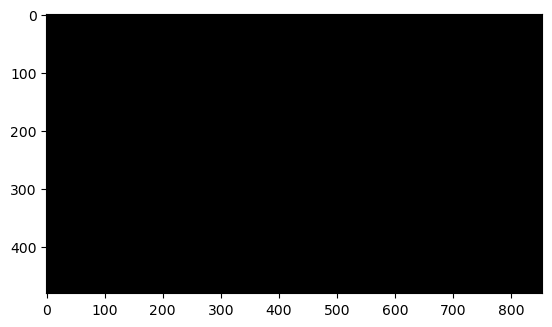

In [31]:
img = plt.imread('0.jpg')   # reading image using its name
plt.imshow(img)
plt.show()

In [32]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [33]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [34]:
from tensorflow.keras.utils import to_categorical  # Correct import

y = data["Class"]  # Ensure correct column access
dummy_y = to_categorical(y)  # Directly use to_categorical

In [35]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [36]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [38]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [39]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [40]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [41]:
X_train = X_train.reshape(155, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(67, 7*7*512)

In [42]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [43]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,693,186 (98.01 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.5788 - loss: 0.7159 - val_accuracy: 0.7463 - val_loss: 0.7193
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8953 - loss: 0.3084 - val_accuracy: 0.7313 - val_loss: 0.8526
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9472 - loss: 0.1903 - val_accuracy: 0.7164 - val_loss: 0.8788
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9805 - loss: 0.1076 - val_accuracy: 0.7164 - val_loss: 0.9484
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9922 - loss: 0.0755 - val_accuracy: 0.7463 - val_loss: 0.8974
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9818 - loss: 0.0584 - val_accuracy: 0.7313 - val_loss: 0.8814
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 1.0000 - loss: 0.0388 - val_accuracy: 0.7761 - val_loss: 0.9144
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 0.7761 - v

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [49]:
test = pd.read_csv('test.csv')

In [50]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [51]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [52]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(9, 7, 7, 512)

In [53]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [54]:
predictions = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [55]:
print(predictions)

[[4.1304361e-06 9.9999583e-01]
 [2.0849089e-04 9.9979156e-01]
 [2.3084176e-03 9.9769163e-01]
 [1.0111728e-03 9.9898881e-01]
 [3.1371014e-03 9.9686289e-01]
 [6.5926492e-01 3.4073514e-01]
 [8.5881180e-01 1.4118823e-01]
 [6.8120223e-01 3.1879780e-01]
 [9.0000844e-01 9.9991508e-02]]


In [56]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")
    

No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident
Accident


In [57]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid = 'AC6490de7a54f81d3b6eeabdf93e0d7099'
auth_token = '7f3aa88050e4f39eb608baed5b21bac8'
client = Client(account_sid, auth_token)

In [58]:
cap = cv2.VideoCapture('Accident-1.mp4')
# cap = cv2.VideoCapture('D:\PARKIFY\trafficflow\trial.mp4')
i=0
flag=0
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/15)%9][0]<predictions[int(i/15)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                predict,
                (50, 50),
                font, 1,
                (0, 255, 255),
                3,
                cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag==1:
    client.messages.create(
                 body="Accident detected in "+locname.address,
                 from_= '+18777804236'
                 to= '+918287905059' , )

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()